# Einführung in die Neuroinformatik - 7. Aufgabenblatt
## Gruppe Q: Dominik Authaler, Marco Deuscher, Carolin Schindler

### Aufgabe 1: Learning Slowdown

#### 1. Untersuchung von $\frac{\partial E}{\partial b_2}$
##### a) $\frac{\partial E}{\partial b_2}$ mit gegebenen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(1,5) \cdot f(1,5) \cdot (1-f(1,5)) \approx 0,24$
##### b) $\frac{\partial E}{\partial b_2}$ mit neuen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(4) \cdot f(4) \cdot (1-f(4)) \approx 0,0347$
##### c) Welches Problem haben wir im letzten Fall und welcher Faktor ist dafür hauptsächlich verantwortlich?
Problem: Gradient sehr klein. D.h. Netzwerk lernt sehr langsam, es dauert also lange bis die Netzwerkausgabe dem Lehrersignal entspricht.  
verantwortlicher Faktor: $f'(u_2)$ mit großem $u_2$

#### 2. zwei lernende Neuronen
##### a) $\frac{\partial E}{\partial b_1}$ berechnen und argumentieren, ob das obige Problem verstärkt oder abgeschwächt wird
$\frac{\partial E}{\partial b_1} = -2\cdot (T-y_2)\cdot f'(u_2)\cdot w_2\cdot f'(u_1)$  
Das Probelm wird verstärkt, da nun $f'(u_i)$ zweimal vorkommt und somit quasi quadratisch eingeht.
##### b) Wie würde sich das Problem bei noch mehr Zwischenschichten weiterentwickeln?
Das Problem würde sich mit jeder weiteren Zwischenschicht verstärken, da mit jeder Schicht in der Ableitung der Fehlerfunktion ein weiterer Faktor $f'(u_i)$ hinzukommt.
##### c) Warum kann sich dadurch die Suche nach einem lokalen Minimum in die Länge ziehen?
Lernvorgang geht sehr langsam voran bis $u_i$ kleiner werden. Je größer also die $u_i$ zu Beginn gewählt wurden, desto länger dauert es bis die Ausgabe dem Lehrersignal entspricht.

#### 3. Untersuchung eines weiteren Problems
##### a) $\frac{\partial E}{\partial b_2}$ und $\frac{\partial E}{\partial b_1}$ mit gegebenen Werten berechnen
$\frac{\partial E}{\partial b_2} = 2 \cdot f(0) \cdot f(0) \cdot (1-f(0)) = 0,25 $  
$\frac{\partial E}{\partial b_1} = 2\cdot f(0) \cdot [f(0) \cdot (1-f(0))]^2 \cdot 100 = 6,25 $
##### b) Wie entwickelt sich die begonnene Folge für noch mehr Zwischenschichten?
$\frac{\partial E}{\partial b_n} = 2\cdot f(0) \cdot [f(0) \cdot (1-f(0))]^n \cdot 100^{n-1} = (0,25)^n \cdot 100^{n-1} = \frac{(25)^n}{100} \rightarrow \infty \text{ für } n \rightarrow \infty$  
mit $n \geq 1$ Schichtnummer von Ausgang ($n=1$) zu Eingang ($n \rightarrow \infty$)
##### c) Was für ein Problem können wir nun beobachten? Warum kann dies die Suche nach einem lokalen Minimum ebenfalls erschweren?
Problem: Gradient sehr groß. D.h. Netzwerk lernt sehr schnell, es kann also passieren, dass lokale Minima (ständig) übersprungen werden.

#### 4. Inwieweit löst die cross entropy-Funktion zumindest zum Teil das hier beschriebene Problem?
$f'(u_i)$ kommt im Gradienten der cross entropy-Funktion einmal weniger vor als im Gradienten der qaudratischen Fehlerunktion. Dadurch treten die obigen Probleme weniger stark auf.


### Aufgabe 2: Flat vs. Deep Networks

#### 1. Untersuchung der Lösung $net_d$
##### a) Netzwerkausgabe für gegebene Eingabe berechnen und überprüfen
$f(x,y) = 0$  
$f((0,0), (1,1)) =(\sum_{i=1}^2 x_i\cdot y_i)\mod 2 = (0\cdot 1 + 0\cdot 1)\mod 2 = 0\mod 2 = 0$
##### b) Netzwerk für $n=3$ erweitern
Pfeile ohne Zahl sind mit $1$ gewichtet
<img src="Blatt07_Bild21b.png"> 
##### c) Welche Rolle kommt den Neuronen in der 1. und 2. Zwischenschicht jeweils zu? Welche Art Zwischenergebnis berechnen sie?
Neuronen in der 1. Zwischenschicht berechenen jeweils für ein festes $i$: $x_i \cdot y_i$.  
Neuronen in der 2. Zwischenschicht berechnen die Anzahl an Neuronen in der 1. Zwischenschicht, die eine $1$ ausgegeben haben.

#### 2. Überprüfung der Gleichung für die Anzahl an benötigten Neuronen
##### a) Erkäre, warum wir die Schwellwertfunktion in unseren Netzwerken nicht verwenden können?
Die Schwellwertfunktion ist nicht stetig und somit auch nicht differenzierbar. Dadurch können wir mit der Schwellwertfunktion als Übertragunsfunktion den Gradienten des quadratischen Fehlers nicht berechnen.
##### b) & c) & d) & e)

In [19]:
import numpy as np
import tensorflow as tf
import tensorflow.keras.backend as K
import itertools
import matplotlib.pyplot as plt

def genTrainingsdaten(n):
    
    comb = np.array(list(itertools.product([0,1], repeat=n)))
    xy = np.array(list(itertools.product(comb,comb)))
    T = []
    for i in range(len(xy)):
        T.append(np.dot(xy[i][0], xy[i][1])%2)
    
    xy = np.where(xy==0, -1, xy)
    T = np.where(T==0, -1, T)
    xy = xy.reshape(len(xy),len(xy[0][0])+len(xy[0][1]))
    
    return xy, T

def train_network(n_hidden, xy, T):
    """
    Trains a neural network and returns the lowest error.
    
    :param n_hidden: Number of hidden neurons to use per layer
                     (as vector to indicate when multiple hidden layers should be used).
                     Forexample, [2] uses one hidden layer with two neurons and
                     [2,2] uses two hidden layers each with two neurons.
    :return: The lowest error (MSE) occurred over all training epochs.
    """
    #Start fresh and at least try to get reproducible results
    tf.reset_default_graph()
    K.clear_session()
    tf.set_random_seed(42)
    np.random.seed(42)
    
    #dimensions
    in_dim = len(xy[0])
    out_dim = len([T[0]])
    if(len(n_hidden) == 1):
        hidden_dim = n_hidden[0]
        anz_hidden = 1
    else:
        hidden_dim = n_hidden[1]
        anz_hidden = n_hidden[0]
        
    #parameters
    initializer = tf.keras.initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=42)
    opt = tf.keras.optimizers.SGD(lr=0.2, decay=0.0001, momentum=0.9,nesterov=True) #lr=0.01
    act = 'tanh'
    model = tf.keras.models.Sequential()
    
    #hidden layer with input
    model.add(tf.keras.layers.Dense(input_dim=in_dim,
                                 units=hidden_dim,
                                 activation=act,
                                 kernel_initializer = initializer))   
    #hidden layers
    for i in range(1, anz_hidden):
        model.add(tf.keras.layers.Dense(units=hidden_dim,
                                     activation=act,
                                     kernel_initializer = initializer))  
    #output layer
    model.add(tf.keras.layers.Dense(units=out_dim,
                                 activation=act))
    
    #compile
    model.compile(optimizer = opt, loss='mse')
    #training
    history = model.fit(xy, T, epochs=300, batch_size=len(T))
    
    return min(history.history['loss'])

n=3
xy, T = genTrainingsdaten(n)
neurons_flat = []
minloss_flat = []
neurons_deep = []
minloss_deep = []

for i in range(1, 2**(n+1)+4+1):
    neurons_flat.append(i)
    minloss_flat.append(train_network([i], xy, T))
for i in range(1, (n+1)+4+1):
    neurons_deep.append(i*2)
    minloss_deep.append(train_network([2, i], xy, T))

Epoch 1/300
64/64 [==============================] - 0s 6ms/sample - loss: 0.5134
Epoch 2/300
64/64 [==============================] - 0s 50us/sample - loss: 0.2880
Epoch 3/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2553
Epoch 4/300
64/64 [==============================] - 0s 39us/sample - loss: 0.2684
Epoch 5/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2744
Epoch 6/300
64/64 [==============================] - 0s 62us/sample - loss: 0.2678
Epoch 7/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2535
Epoch 8/300
64/64 [==============================] - 0s 22us/sample - loss: 0.2413
Epoch 9/300
64/64 [==============================] - 0s 33us/sample - loss: 0.2384
Epoch 10/300
64/64 [==============================] - 0s 408us/sample - loss: 0.2392
Epoch 11/300
64/64 [==============================] - 0s 78us/sample - loss: 0.2347
Epoch 12/300
64/64 [==============================] - 0s 47us/sample - loss: 0.2256
Epo

Epoch 99/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1966
Epoch 100/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1966
Epoch 101/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1966
Epoch 102/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1966
Epoch 103/300
64/64 [==============================] - 0s 56us/sample - loss: 0.1966
Epoch 104/300
64/64 [==============================] - 0s 53us/sample - loss: 0.1966
Epoch 105/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1966
Epoch 106/300
64/64 [==============================] - 0s 57us/sample - loss: 0.1966
Epoch 107/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1966
Epoch 108/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1966
Epoch 109/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1965
Epoch 110/300
64/64 [==============================] - 0s 33us/sam

Epoch 196/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1961
Epoch 197/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1961
Epoch 198/300
64/64 [==============================] - 0s 58us/sample - loss: 0.1961
Epoch 199/300
64/64 [==============================] - 0s 49us/sample - loss: 0.1961
Epoch 200/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1961
Epoch 201/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1961
Epoch 202/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1961
Epoch 203/300
64/64 [==============================] - 0s 44us/sample - loss: 0.1961
Epoch 204/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1961
Epoch 205/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1961
Epoch 206/300
64/64 [==============================] - 0s 87us/sample - loss: 0.1961
Epoch 207/300
64/64 [==============================] - 0s 62us/samp

Epoch 293/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1960
Epoch 294/300
64/64 [==============================] - 0s 68us/sample - loss: 0.1960
Epoch 295/300
64/64 [==============================] - 0s 60us/sample - loss: 0.1960
Epoch 296/300
64/64 [==============================] - 0s 65us/sample - loss: 0.1960
Epoch 297/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1960
Epoch 298/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1960
Epoch 299/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1960
Epoch 300/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1960
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 0.5476
Epoch 2/300
64/64 [==============================] - 0s 260us/sample - loss: 0.2917
Epoch 3/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2493
Epoch 4/300
64/64 [==============================] - 0s 16us/sample - l

Epoch 91/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1957
Epoch 92/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1957
Epoch 93/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1957
Epoch 94/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1956
Epoch 95/300
64/64 [==============================] - 0s 19us/sample - loss: 0.1956
Epoch 96/300
64/64 [==============================] - 0s 26us/sample - loss: 0.1956
Epoch 97/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1956
Epoch 98/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1955
Epoch 99/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1955
Epoch 100/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1955
Epoch 101/300
64/64 [==============================] - 0s 65us/sample - loss: 0.1955
Epoch 102/300
64/64 [==============================] - 0s 15us/sample - loss

Epoch 188/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1797
Epoch 189/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1792
Epoch 190/300
64/64 [==============================] - 0s 88us/sample - loss: 0.1788
Epoch 191/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1783
Epoch 192/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1778
Epoch 193/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1773
Epoch 194/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1767
Epoch 195/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1762
Epoch 196/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1756
Epoch 197/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1751
Epoch 198/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1745
Epoch 199/300
64/64 [==============================] - 0s 32us/samp

Epoch 285/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1486
Epoch 286/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1485
Epoch 287/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1484
Epoch 288/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1483
Epoch 289/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1482
Epoch 290/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1481
Epoch 291/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1480
Epoch 292/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1479
Epoch 293/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1478
Epoch 294/300
64/64 [==============================] - 0s 15us/sample - loss: 0.1477
Epoch 295/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1476
Epoch 296/300
64/64 [==============================] - 0s 16us/sa

Epoch 83/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1912
Epoch 84/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1909
Epoch 85/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1906
Epoch 86/300
64/64 [==============================] - 0s 20us/sample - loss: 0.1902
Epoch 87/300
64/64 [==============================] - 0s 63us/sample - loss: 0.1899
Epoch 88/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1896
Epoch 89/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1892
Epoch 90/300
64/64 [==============================] - 0s 19us/sample - loss: 0.1889
Epoch 91/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1885
Epoch 92/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1881
Epoch 93/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1877
Epoch 94/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 180/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1373
Epoch 181/300
64/64 [==============================] - 0s 63us/sample - loss: 0.1363
Epoch 182/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1351
Epoch 183/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1336
Epoch 184/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1318
Epoch 185/300
64/64 [==============================] - 0s 60us/sample - loss: 0.1296
Epoch 186/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1269
Epoch 187/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1237
Epoch 188/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1200
Epoch 189/300
64/64 [==============================] - 0s 52us/sample - loss: 0.1159
Epoch 190/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1119
Epoch 191/300
64/64 [==============================] - 0s 68us/samp

Epoch 277/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0705
Epoch 278/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0705
Epoch 279/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0704
Epoch 280/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0703
Epoch 281/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0703
Epoch 282/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0702
Epoch 283/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0701
Epoch 284/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0701
Epoch 285/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0700
Epoch 286/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0699
Epoch 287/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0699
Epoch 288/300
64/64 [==============================] - 0s 25us/sa

Epoch 75/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1113
Epoch 76/300
64/64 [==============================] - 0s 45us/sample - loss: 0.1089
Epoch 77/300
64/64 [==============================] - 0s 44us/sample - loss: 0.1066
Epoch 78/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1043
Epoch 79/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1022
Epoch 80/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1001
Epoch 81/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0982
Epoch 82/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0963
Epoch 83/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0946
Epoch 84/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0930
Epoch 85/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0914
Epoch 86/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 172/300
64/64 [==============================] - 0s 93us/sample - loss: 0.0430
Epoch 173/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0429
Epoch 174/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0428
Epoch 175/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0427
Epoch 176/300
64/64 [==============================] - 0s 67us/sample - loss: 0.0426
Epoch 177/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0425
Epoch 178/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0424
Epoch 179/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0423
Epoch 180/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0422
Epoch 181/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0421
Epoch 182/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0420
Epoch 183/300
64/64 [==============================] - 0s 31us/sa

Epoch 269/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0340
Epoch 270/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0336
Epoch 271/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0332
Epoch 272/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0328
Epoch 273/300
64/64 [==============================] - 0s 67us/sample - loss: 0.0324
Epoch 274/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0319
Epoch 275/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0315
Epoch 276/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0311
Epoch 277/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0307
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0304
Epoch 279/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0301
Epoch 280/300
64/64 [==============================] - 0s 31us/samp

Epoch 67/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0599
Epoch 68/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0578
Epoch 69/300
64/64 [==============================] - 0s 70us/sample - loss: 0.0558
Epoch 70/300
64/64 [==============================] - 0s 60us/sample - loss: 0.0539
Epoch 71/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0521
Epoch 72/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0503
Epoch 73/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0485
Epoch 74/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0468
Epoch 75/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0451
Epoch 76/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0435
Epoch 77/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0419
Epoch 78/300
64/64 [==============================] - 0s 65us/sample - loss:

Epoch 164/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0086
Epoch 165/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0084
Epoch 166/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0082
Epoch 167/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0080
Epoch 168/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0079
Epoch 169/300
64/64 [==============================] - 0s 71us/sample - loss: 0.0077
Epoch 170/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0075
Epoch 171/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0074
Epoch 172/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0072
Epoch 173/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0071
Epoch 174/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0069
Epoch 175/300
64/64 [==============================] - 0s 31us/samp

Epoch 261/300
64/64 [==============================] - 0s 59us/sample - loss: 0.0100
Epoch 262/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0100
Epoch 263/300
64/64 [==============================] - 0s 76us/sample - loss: 0.0100
Epoch 264/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0099
Epoch 265/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0099
Epoch 266/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0098
Epoch 267/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0097
Epoch 268/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0096
Epoch 269/300
64/64 [==============================] - 0s 102us/sample - loss: 0.0096
Epoch 270/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0095
Epoch 271/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0094
Epoch 272/300
64/64 [==============================] - 0s 37us/sampl

Epoch 59/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0452
Epoch 60/300
64/64 [==============================] - 0s 312us/sample - loss: 0.0424
Epoch 61/300
64/64 [==============================] - 0s 15us/sample - loss: 0.0398
Epoch 62/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0374
Epoch 63/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0352
Epoch 64/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0332
Epoch 65/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0315
Epoch 66/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0300
Epoch 67/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0288
Epoch 68/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0279
Epoch 69/300
64/64 [==============================] - 0s 56us/sample - loss: 0.0271
Epoch 70/300
64/64 [==============================] - 0s 31us/sample - loss

Epoch 156/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0167
Epoch 157/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0167
Epoch 158/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0167
Epoch 159/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0167
Epoch 160/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0167
Epoch 161/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0167
Epoch 162/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0167
Epoch 163/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0167
Epoch 164/300
64/64 [==============================] - 0s 81us/sample - loss: 0.0166
Epoch 165/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 166/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 167/300
64/64 [==============================] - 0s 16us/sa

Epoch 253/300
64/64 [==============================] - 0s 20us/sample - loss: 0.0161
Epoch 254/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 255/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0161
Epoch 256/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 257/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 258/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0161
Epoch 259/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0161
Epoch 260/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0161
Epoch 261/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 262/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0161
Epoch 263/300
64/64 [==============================] - 0s 137us/sample - loss: 0.0161
Epoch 264/300
64/64 [==============================] - 0s 33us/sam

64/64 [==============================] - 0s 98us/sample - loss: 0.1402
Epoch 51/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1371
Epoch 52/300
64/64 [==============================] - 0s 53us/sample - loss: 0.1339
Epoch 53/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1306
Epoch 54/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1274
Epoch 55/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1241
Epoch 56/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1209
Epoch 57/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1176
Epoch 58/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1143
Epoch 59/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1110
Epoch 60/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1077
Epoch 61/300
64/64 [==============================] - 0s 92us/sample - loss: 0.1043
Epoch 6

Epoch 148/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0171
Epoch 149/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0171
Epoch 150/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0171
Epoch 151/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0171
Epoch 152/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0171
Epoch 153/300
64/64 [==============================] - 0s 89us/sample - loss: 0.0170
Epoch 154/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0170
Epoch 155/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0170
Epoch 156/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0170
Epoch 157/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0170
Epoch 158/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0169
Epoch 159/300
64/64 [==============================] - 0s 16us/samp

Epoch 245/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0162
Epoch 246/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0162
Epoch 247/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0162
Epoch 248/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0162
Epoch 249/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 250/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0161
Epoch 251/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 252/300
64/64 [==============================] - 0s 569us/sample - loss: 0.0161
Epoch 253/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0161
Epoch 254/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 255/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0161
Epoch 256/300
64/64 [==============================] - 0s 0s/sam

Epoch 43/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1695
Epoch 44/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1664
Epoch 45/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1631
Epoch 46/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1597
Epoch 47/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1561
Epoch 48/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1524
Epoch 49/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1486
Epoch 50/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1448
Epoch 51/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1410
Epoch 52/300
64/64 [==============================] - 0s 50us/sample - loss: 0.1373
Epoch 53/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1336
Epoch 54/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1

Epoch 141/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0051
Epoch 142/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0050
Epoch 143/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0048
Epoch 144/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0047
Epoch 145/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0045
Epoch 146/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0044
Epoch 147/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0043
Epoch 148/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0041
Epoch 149/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0040
Epoch 150/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0039
Epoch 151/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0038
Epoch 152/300
64/64 [==============================] - 0s 24us/sample

Epoch 237/300
64/64 [==============================] - 0s 16us/sample - loss: 7.8892e-04
Epoch 238/300
64/64 [==============================] - 0s 31us/sample - loss: 7.8082e-04
Epoch 239/300
64/64 [==============================] - 0s 56us/sample - loss: 7.7288e-04
Epoch 240/300
64/64 [==============================] - 0s 52us/sample - loss: 7.6511e-04
Epoch 241/300
64/64 [==============================] - 0s 48us/sample - loss: 7.5750e-04
Epoch 242/300
64/64 [==============================] - 0s 16us/sample - loss: 7.5004e-04
Epoch 243/300
64/64 [==============================] - 0s 31us/sample - loss: 7.4274e-04
Epoch 244/300
64/64 [==============================] - 0s 0s/sample - loss: 7.3559e-04
Epoch 245/300
64/64 [==============================] - 0s 62us/sample - loss: 7.2858e-04
Epoch 246/300
64/64 [==============================] - 0s 62us/sample - loss: 7.2170e-04
Epoch 247/300
64/64 [==============================] - 0s 31us/sample - loss: 7.1496e-04
Epoch 248/300
64/64 [==

Epoch 31/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2001
Epoch 32/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1991
Epoch 33/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1980
Epoch 34/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1969
Epoch 35/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1957
Epoch 36/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1945
Epoch 37/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1931
Epoch 38/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1917
Epoch 39/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1901
Epoch 40/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1884
Epoch 41/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1866
Epoch 42/300
64/64 [==============================] - 0s 16us/sample - loss: 0

Epoch 129/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0087
Epoch 130/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0085
Epoch 131/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0083
Epoch 132/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0081
Epoch 133/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0079
Epoch 134/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0077
Epoch 135/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0075
Epoch 136/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0074
Epoch 137/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0072
Epoch 138/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0070
Epoch 139/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0068
Epoch 140/300
64/64 [==============================] - 0s 0s/sample -

Epoch 226/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0011
Epoch 227/300
64/64 [==============================] - 0s 58us/sample - loss: 0.0011
Epoch 228/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0011
Epoch 229/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0011
Epoch 230/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 231/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0010
Epoch 232/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0010
Epoch 233/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0010
Epoch 234/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0010
Epoch 235/300
64/64 [==============================] - 0s 34us/sample - loss: 9.8797e-04
Epoch 236/300
64/64 [==============================] - 0s 31us/sample - loss: 9.7595e-04
Epoch 237/300
64/64 [==============================] - 0s

Epoch 20/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1813
Epoch 21/300
64/64 [==============================] - 0s 81us/sample - loss: 0.1786
Epoch 22/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1756
Epoch 23/300
64/64 [==============================] - 0s 15us/sample - loss: 0.1724
Epoch 24/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1692
Epoch 25/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1658
Epoch 26/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1622
Epoch 27/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1585
Epoch 28/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1547
Epoch 29/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1509
Epoch 30/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1470
Epoch 31/300
64/64 [==============================] - 0s 0s/sample - loss: 0.143

Epoch 118/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0026
Epoch 119/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0025
Epoch 120/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0025
Epoch 121/300
64/64 [==============================] - 0s 60us/sample - loss: 0.0024
Epoch 122/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0023
Epoch 123/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0023
Epoch 124/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0022
Epoch 125/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0022
Epoch 126/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0021
Epoch 127/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0021
Epoch 128/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0021
Epoch 129/300
64/64 [==============================] - 0s 35us/samp

Epoch 214/300
64/64 [==============================] - 0s 47us/sample - loss: 7.8580e-04
Epoch 215/300
64/64 [==============================] - 0s 52us/sample - loss: 7.7976e-04
Epoch 216/300
64/64 [==============================] - 0s 16us/sample - loss: 7.7378e-04
Epoch 217/300
64/64 [==============================] - 0s 71us/sample - loss: 7.6788e-04
Epoch 218/300
64/64 [==============================] - 0s 16us/sample - loss: 7.6205e-04
Epoch 219/300
64/64 [==============================] - 0s 67us/sample - loss: 7.5629e-04
Epoch 220/300
64/64 [==============================] - 0s 0s/sample - loss: 7.5060e-04
Epoch 221/300
64/64 [==============================] - 0s 16us/sample - loss: 7.4497e-04
Epoch 222/300
64/64 [==============================] - 0s 31us/sample - loss: 7.3942e-04
Epoch 223/300
64/64 [==============================] - 0s 16us/sample - loss: 7.3393e-04
Epoch 224/300
64/64 [==============================] - 0s 16us/sample - loss: 7.2850e-04
Epoch 225/300
64/64 [==

Epoch 7/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2851
Epoch 8/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2790
Epoch 9/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2711
Epoch 10/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2618
Epoch 11/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2510
Epoch 12/300
64/64 [==============================] - 0s 34us/sample - loss: 0.2393
Epoch 13/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2276
Epoch 14/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2172
Epoch 15/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2089
Epoch 16/300
64/64 [==============================] - 0s 60us/sample - loss: 0.2041
Epoch 17/300
64/64 [==============================] - 0s 21us/sample - loss: 0.2033
Epoch 18/300
64/64 [==============================] - 0s 30us/sample - loss: 0.2050

Epoch 105/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0042
Epoch 106/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0040
Epoch 107/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0038
Epoch 108/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0036
Epoch 109/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0034
Epoch 110/300
64/64 [==============================] - 0s 15us/sample - loss: 0.0033
Epoch 111/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0031
Epoch 112/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0030
Epoch 113/300
64/64 [==============================] - 0s 17us/sample - loss: 0.0029
Epoch 114/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0027
Epoch 115/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0026
Epoch 116/300
64/64 [==============================] - 0s 31us/sa

Epoch 200/300
64/64 [==============================] - 0s 15us/sample - loss: 6.6386e-04
Epoch 201/300
64/64 [==============================] - 0s 32us/sample - loss: 6.5846e-04
Epoch 202/300
64/64 [==============================] - 0s 33us/sample - loss: 6.5315e-04
Epoch 203/300
64/64 [==============================] - 0s 48us/sample - loss: 6.4792e-04
Epoch 204/300
64/64 [==============================] - 0s 30us/sample - loss: 6.4277e-04
Epoch 205/300
64/64 [==============================] - 0s 26us/sample - loss: 6.3771e-04
Epoch 206/300
64/64 [==============================] - 0s 0s/sample - loss: 6.3272e-04
Epoch 207/300
64/64 [==============================] - 0s 31us/sample - loss: 6.2781e-04
Epoch 208/300
64/64 [==============================] - 0s 16us/sample - loss: 6.2298e-04
Epoch 209/300
64/64 [==============================] - 0s 62us/sample - loss: 6.1822e-04
Epoch 210/300
64/64 [==============================] - 0s 22us/sample - loss: 6.1353e-04
Epoch 211/300
64/64 [==

Epoch 293/300
64/64 [==============================] - 0s 54us/sample - loss: 3.7277e-04
Epoch 294/300
64/64 [==============================] - 0s 30us/sample - loss: 3.7096e-04
Epoch 295/300
64/64 [==============================] - 0s 49us/sample - loss: 3.6916e-04
Epoch 296/300
64/64 [==============================] - 0s 32us/sample - loss: 3.6738e-04
Epoch 297/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6562e-04
Epoch 298/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6387e-04
Epoch 299/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6213e-04
Epoch 300/300
64/64 [==============================] - 0s 67us/sample - loss: 3.6041e-04
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 0.8353
Epoch 2/300
64/64 [==============================] - 0s 0s/sample - loss: 0.3798
Epoch 3/300
64/64 [==============================] - 0s 45us/sample - loss: 0.2521
Epoch 4/300
64/64 [=======================

Epoch 91/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0266
Epoch 92/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0257
Epoch 93/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0249
Epoch 94/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0243
Epoch 95/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0237
Epoch 96/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0232
Epoch 97/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0228
Epoch 98/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0224
Epoch 99/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0221
Epoch 100/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0218
Epoch 101/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0215
Epoch 102/300
64/64 [==============================] - 0s 36us/sample - loss: 0.

Epoch 188/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0166
Epoch 189/300
64/64 [==============================] - 0s 61us/sample - loss: 0.0166
Epoch 190/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0166
Epoch 191/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0166
Epoch 192/300
64/64 [==============================] - 0s 56us/sample - loss: 0.0166
Epoch 193/300
64/64 [==============================] - 0s 454us/sample - loss: 0.0166
Epoch 194/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 195/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0166
Epoch 196/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0166
Epoch 197/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0165
Epoch 198/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0165
Epoch 199/300
64/64 [==============================] - 0s 16us/s

Epoch 285/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0161
Epoch 286/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0161
Epoch 287/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0161
Epoch 288/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 289/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 290/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0161
Epoch 291/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 292/300
64/64 [==============================] - 0s 56us/sample - loss: 0.0161
Epoch 293/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0161
Epoch 294/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0161
Epoch 295/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0161
Epoch 296/300
64/64 [==============================] - 0s 16us/sa

Epoch 83/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0385
Epoch 84/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0368
Epoch 85/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0350
Epoch 86/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0332
Epoch 87/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0314
Epoch 88/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0296
Epoch 89/300
64/64 [==============================] - 0s 75us/sample - loss: 0.0279
Epoch 90/300
64/64 [==============================] - 0s 20us/sample - loss: 0.0261
Epoch 91/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0244
Epoch 92/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0227
Epoch 93/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0211
Epoch 94/300
64/64 [==============================] - 0s 15us/sample - loss: 0

Epoch 180/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0012
Epoch 181/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0012
Epoch 182/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0011
Epoch 183/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0011
Epoch 184/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0011
Epoch 185/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0011
Epoch 186/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0011
Epoch 187/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 188/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 189/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0011
Epoch 190/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0010
Epoch 191/300
64/64 [==============================] - 0s 65us/samp

Epoch 275/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0042
Epoch 276/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0039
Epoch 277/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0037
Epoch 278/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0034
Epoch 279/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0032
Epoch 280/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0030
Epoch 281/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0028
Epoch 282/300
64/64 [==============================] - 0s 14us/sample - loss: 0.0026
Epoch 283/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0025
Epoch 284/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0023
Epoch 285/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0022
Epoch 286/300
64/64 [==============================] - 0s 18us/sa

Epoch 73/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0093
Epoch 74/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0085
Epoch 75/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0078
Epoch 76/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0071
Epoch 77/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0065
Epoch 78/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0060
Epoch 79/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0055
Epoch 80/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0051
Epoch 81/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0048
Epoch 82/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0046
Epoch 83/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0043
Epoch 84/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0

Epoch 169/300
64/64 [==============================] - 0s 31us/sample - loss: 6.6739e-04
Epoch 170/300
64/64 [==============================] - 0s 16us/sample - loss: 6.6067e-04
Epoch 171/300
64/64 [==============================] - 0s 16us/sample - loss: 6.5408e-04
Epoch 172/300
64/64 [==============================] - 0s 30us/sample - loss: 6.4762e-04
Epoch 173/300
64/64 [==============================] - 0s 16us/sample - loss: 6.4129e-04
Epoch 174/300
64/64 [==============================] - 0s 31us/sample - loss: 6.3507e-04
Epoch 175/300
64/64 [==============================] - 0s 28us/sample - loss: 6.2896e-04
Epoch 176/300
64/64 [==============================] - 0s 0s/sample - loss: 6.2297e-04
Epoch 177/300
64/64 [==============================] - 0s 43us/sample - loss: 6.1709e-04
Epoch 178/300
64/64 [==============================] - 0s 0s/sample - loss: 6.1132e-04
Epoch 179/300
64/64 [==============================] - 0s 47us/sample - loss: 6.0565e-04
Epoch 180/300
64/64 [====

Epoch 262/300
64/64 [==============================] - 0s 29us/sample - loss: 3.3927e-04
Epoch 263/300
64/64 [==============================] - 0s 39us/sample - loss: 3.3745e-04
Epoch 264/300
64/64 [==============================] - 0s 29us/sample - loss: 3.3565e-04
Epoch 265/300
64/64 [==============================] - 0s 0s/sample - loss: 3.3387e-04
Epoch 266/300
64/64 [==============================] - 0s 31us/sample - loss: 3.3211e-04
Epoch 267/300
64/64 [==============================] - 0s 31us/sample - loss: 3.3037e-04
Epoch 268/300
64/64 [==============================] - 0s 40us/sample - loss: 3.2864e-04
Epoch 269/300
64/64 [==============================] - 0s 16us/sample - loss: 3.2694e-04
Epoch 270/300
64/64 [==============================] - 0s 72us/sample - loss: 3.2524e-04
Epoch 271/300
64/64 [==============================] - 0s 47us/sample - loss: 3.2357e-04
Epoch 272/300
64/64 [==============================] - 0s 16us/sample - loss: 3.2191e-04
Epoch 273/300
64/64 [==

Epoch 58/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0727
Epoch 59/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0698
Epoch 60/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0672
Epoch 61/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0646
Epoch 62/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0623
Epoch 63/300
64/64 [==============================] - 0s 77us/sample - loss: 0.0601
Epoch 64/300
64/64 [==============================] - 0s 58us/sample - loss: 0.0579
Epoch 65/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0558
Epoch 66/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0538
Epoch 67/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0518
Epoch 68/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0499
Epoch 69/300
64/64 [==============================] - 0s 83us/sample - loss:

Epoch 156/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0022
Epoch 157/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0022
Epoch 158/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0021
Epoch 159/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0021
Epoch 160/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0021
Epoch 161/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0020
Epoch 162/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0020
Epoch 163/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0019
Epoch 164/300
64/64 [==============================] - 0s 28us/sample - loss: 0.0019
Epoch 165/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0019
Epoch 166/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0018
Epoch 167/300
64/64 [==============================] - 0s 16us/samp

Epoch 252/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0167
Epoch 253/300
64/64 [==============================] - 0s 50us/sample - loss: 0.0166
Epoch 254/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0156
Epoch 255/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0153
Epoch 256/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0143
Epoch 257/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0139
Epoch 258/300
64/64 [==============================] - 0s 93us/sample - loss: 0.0130
Epoch 259/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0126
Epoch 260/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0117
Epoch 261/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0112
Epoch 262/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0104
Epoch 263/300
64/64 [==============================] - 0s 24us/samp

Epoch 50/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0613
Epoch 51/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0562
Epoch 52/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0515
Epoch 53/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0473
Epoch 54/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0436
Epoch 55/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0403
Epoch 56/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0375
Epoch 57/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0350
Epoch 58/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0329
Epoch 59/300
64/64 [==============================] - 0s 51us/sample - loss: 0.0311
Epoch 60/300
64/64 [==============================] - 0s 48us/sample - loss: 0.0295
Epoch 61/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0

Epoch 148/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0016
Epoch 149/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0016
Epoch 150/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0015
Epoch 151/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0015
Epoch 152/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0015
Epoch 153/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0014
Epoch 154/300
64/64 [==============================] - 0s 52us/sample - loss: 0.0014
Epoch 155/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0014
Epoch 156/300
64/64 [==============================] - 0s 25us/sample - loss: 0.0013
Epoch 157/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0013
Epoch 158/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0013
Epoch 159/300
64/64 [==============================] - 0s 47us/sa

Epoch 242/300
64/64 [==============================] - 0s 21us/sample - loss: 4.5930e-04
Epoch 243/300
64/64 [==============================] - 0s 55us/sample - loss: 4.5580e-04
Epoch 244/300
64/64 [==============================] - 0s 0s/sample - loss: 4.5235e-04
Epoch 245/300
64/64 [==============================] - 0s 41us/sample - loss: 4.4895e-04
Epoch 246/300
64/64 [==============================] - 0s 39us/sample - loss: 4.4560e-04
Epoch 247/300
64/64 [==============================] - 0s 65us/sample - loss: 4.4231e-04
Epoch 248/300
64/64 [==============================] - 0s 45us/sample - loss: 4.3906e-04
Epoch 249/300
64/64 [==============================] - 0s 15us/sample - loss: 4.3585e-04
Epoch 250/300
64/64 [==============================] - 0s 16us/sample - loss: 4.3269e-04
Epoch 251/300
64/64 [==============================] - 0s 38us/sample - loss: 4.2958e-04
Epoch 252/300
64/64 [==============================] - 0s 64us/sample - loss: 4.2651e-04
Epoch 253/300
64/64 [==

Epoch 37/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1296
Epoch 38/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1257
Epoch 39/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1217
Epoch 40/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1177
Epoch 41/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1136
Epoch 42/300
64/64 [==============================] - 0s 30us/sample - loss: 0.1094
Epoch 43/300
64/64 [==============================] - 0s 60us/sample - loss: 0.1051
Epoch 44/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1006
Epoch 45/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0960
Epoch 46/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0913
Epoch 47/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0865
Epoch 48/300
64/64 [==============================] - 0s 32us/sample - loss:

Epoch 135/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 136/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0011
Epoch 137/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0011
Epoch 138/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0010
Epoch 139/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0010
Epoch 140/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0010
Epoch 141/300
64/64 [==============================] - 0s 16us/sample - loss: 9.9778e-04
Epoch 142/300
64/64 [==============================] - 0s 65us/sample - loss: 9.8164e-04
Epoch 143/300
64/64 [==============================] - 0s 32us/sample - loss: 9.6600e-04
Epoch 144/300
64/64 [==============================] - 0s 16us/sample - loss: 9.5083e-04
Epoch 145/300
64/64 [==============================] - 0s 16us/sample - loss: 9.3611e-04
Epoch 146/300
64/64 [========================

Epoch 228/300
64/64 [==============================] - 0s 35us/sample - loss: 9.3346e-04
Epoch 229/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0011
Epoch 230/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0014
Epoch 231/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0018
Epoch 232/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0023
Epoch 233/300
64/64 [==============================] - 0s 41us/sample - loss: 0.0029
Epoch 234/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0037
Epoch 235/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0047
Epoch 236/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0060
Epoch 237/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0073
Epoch 238/300
64/64 [==============================] - 0s 23us/sample - loss: 0.0088
Epoch 239/300
64/64 [==============================] - 0s 16us/

Epoch 25/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1765
Epoch 26/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1734
Epoch 27/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1706
Epoch 28/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1678
Epoch 29/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1647
Epoch 30/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1612
Epoch 31/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1575
Epoch 32/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1535
Epoch 33/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1495
Epoch 34/300
64/64 [==============================] - 0s 27us/sample - loss: 0.1457
Epoch 35/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1420
Epoch 36/300
64/64 [==============================] - 0s 27us/sample - loss: 0

Epoch 123/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0013
Epoch 124/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0012
Epoch 125/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0012
Epoch 126/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0012
Epoch 127/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0012
Epoch 128/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0011
Epoch 129/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0011
Epoch 130/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0011
Epoch 131/300
64/64 [==============================] - 0s 18us/sample - loss: 0.0011
Epoch 132/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0010
Epoch 133/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0010
Epoch 134/300
64/64 [==============================] - 0s 16us/samp

Epoch 216/300
64/64 [==============================] - 0s 31us/sample - loss: 4.3956e-04
Epoch 217/300
64/64 [==============================] - 0s 17us/sample - loss: 4.3658e-04
Epoch 218/300
64/64 [==============================] - 0s 36us/sample - loss: 4.3365e-04
Epoch 219/300
64/64 [==============================] - 0s 27us/sample - loss: 4.3076e-04
Epoch 220/300
64/64 [==============================] - 0s 16us/sample - loss: 4.2790e-04
Epoch 221/300
64/64 [==============================] - 0s 31us/sample - loss: 4.2509e-04
Epoch 222/300
64/64 [==============================] - 0s 31us/sample - loss: 4.2231e-04
Epoch 223/300
64/64 [==============================] - 0s 32us/sample - loss: 4.1957e-04
Epoch 224/300
64/64 [==============================] - 0s 0s/sample - loss: 4.1687e-04
Epoch 225/300
64/64 [==============================] - 0s 0s/sample - loss: 4.1420e-04
Epoch 226/300
64/64 [==============================] - 0s 62us/sample - loss: 4.1158e-04
Epoch 227/300
64/64 [====

Epoch 11/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2381
Epoch 12/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2270
Epoch 13/300
64/64 [==============================] - 0s 28us/sample - loss: 0.2181
Epoch 14/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2120
Epoch 15/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2088
Epoch 16/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2082
Epoch 17/300
64/64 [==============================] - 0s 31us/sample - loss: 0.2090
Epoch 18/300
64/64 [==============================] - 0s 34us/sample - loss: 0.2091
Epoch 19/300
64/64 [==============================] - 0s 25us/sample - loss: 0.2077
Epoch 20/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2051
Epoch 21/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2020
Epoch 22/300
64/64 [==============================] - 0s 137us/sample - loss: 0.

Epoch 109/300
64/64 [==============================] - 0s 86us/sample - loss: 0.0013
Epoch 110/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0012
Epoch 111/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0012
Epoch 112/300
64/64 [==============================] - 0s 12us/sample - loss: 0.0012
Epoch 113/300
64/64 [==============================] - 0s 82us/sample - loss: 0.0011
Epoch 114/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0011
Epoch 115/300
64/64 [==============================] - 0s 14us/sample - loss: 0.0011
Epoch 116/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0011
Epoch 117/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0010
Epoch 118/300
64/64 [==============================] - 0s 82us/sample - loss: 0.0010
Epoch 119/300
64/64 [==============================] - 0s 55us/sample - loss: 0.0010
Epoch 120/300
64/64 [==============================] - 0s 42us/sa

Epoch 202/300
64/64 [==============================] - 0s 20us/sample - loss: 3.8653e-04
Epoch 203/300
64/64 [==============================] - 0s 15us/sample - loss: 3.8376e-04
Epoch 204/300
64/64 [==============================] - 0s 51us/sample - loss: 3.8103e-04
Epoch 205/300
64/64 [==============================] - 0s 0s/sample - loss: 3.7835e-04
Epoch 206/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7570e-04
Epoch 207/300
64/64 [==============================] - 0s 46us/sample - loss: 3.7308e-04
Epoch 208/300
64/64 [==============================] - 0s 78us/sample - loss: 3.7051e-04
Epoch 209/300
64/64 [==============================] - 0s 86us/sample - loss: 3.6797e-04
Epoch 210/300
64/64 [==============================] - 0s 16us/sample - loss: 3.6546e-04
Epoch 211/300
64/64 [==============================] - 0s 93us/sample - loss: 3.6299e-04
Epoch 212/300
64/64 [==============================] - 0s 63us/sample - loss: 3.6056e-04
Epoch 213/300
64/64 [==

Epoch 296/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0084
Epoch 297/300
64/64 [==============================] - 0s 89us/sample - loss: 0.0080
Epoch 298/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0078
Epoch 299/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0074
Epoch 300/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0072
Epoch 1/300
64/64 [==============================] - 0s 7ms/sample - loss: 0.6508
Epoch 2/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2262
Epoch 3/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2354
Epoch 4/300
64/64 [==============================] - 0s 40us/sample - loss: 0.2481
Epoch 5/300
64/64 [==============================] - 0s 24us/sample - loss: 0.2551
Epoch 6/300
64/64 [==============================] - 0s 19us/sample - loss: 0.2568
Epoch 7/300
64/64 [==============================] - 0s 0s/sample - loss: 0.2551
E

Epoch 94/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0032
Epoch 95/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0030
Epoch 96/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0029
Epoch 97/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0027
Epoch 98/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0026
Epoch 99/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0025
Epoch 100/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0024
Epoch 101/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0022
Epoch 102/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0021
Epoch 103/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0020
Epoch 104/300
64/64 [==============================] - 0s 37us/sample - loss: 0.0019
Epoch 105/300
64/64 [==============================] - 0s 16us/sample -

Epoch 190/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0066
Epoch 191/300
64/64 [==============================] - 0s 26us/sample - loss: 0.0061
Epoch 192/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0058
Epoch 193/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0053
Epoch 194/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0050
Epoch 195/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0046
Epoch 196/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0044
Epoch 197/300
64/64 [==============================] - 0s 57us/sample - loss: 0.0040
Epoch 198/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0038
Epoch 199/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0035
Epoch 200/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0033
Epoch 201/300
64/64 [==============================] - 0s 54us/samp

Epoch 284/300
64/64 [==============================] - 0s 43us/sample - loss: 5.1094e-04
Epoch 285/300
64/64 [==============================] - 0s 37us/sample - loss: 5.1435e-04
Epoch 286/300
64/64 [==============================] - 0s 44us/sample - loss: 5.1869e-04
Epoch 287/300
64/64 [==============================] - 0s 37us/sample - loss: 5.2289e-04
Epoch 288/300
64/64 [==============================] - 0s 37us/sample - loss: 5.2808e-04
Epoch 289/300
64/64 [==============================] - 0s 16us/sample - loss: 5.3303e-04
Epoch 290/300
64/64 [==============================] - 0s 53us/sample - loss: 5.3915e-04
Epoch 291/300
64/64 [==============================] - 0s 84us/sample - loss: 5.4513e-04
Epoch 292/300
64/64 [==============================] - 0s 0s/sample - loss: 5.5231e-04
Epoch 293/300
64/64 [==============================] - 0s 66us/sample - loss: 5.5929e-04
Epoch 294/300
64/64 [==============================] - 0s 64us/sample - loss: 5.6761e-04
Epoch 295/300
64/64 [==

Epoch 81/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1975
Epoch 82/300
64/64 [==============================] - 0s 20us/sample - loss: 0.1974
Epoch 83/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1972
Epoch 84/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1971
Epoch 85/300
64/64 [==============================] - 0s 19us/sample - loss: 0.1971
Epoch 86/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1970
Epoch 87/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1969
Epoch 88/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1969
Epoch 89/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1969
Epoch 90/300
64/64 [==============================] - 0s 42us/sample - loss: 0.1968
Epoch 91/300
64/64 [==============================] - 0s 37us/sample - loss: 0.1968
Epoch 92/300
64/64 [==============================] - 0s 16us/sample - loss:

Epoch 178/300
64/64 [==============================] - 0s 76us/sample - loss: 0.1960
Epoch 179/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 180/300
64/64 [==============================] - 0s 40us/sample - loss: 0.1960
Epoch 181/300
64/64 [==============================] - 0s 25us/sample - loss: 0.1960
Epoch 182/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 183/300
64/64 [==============================] - 0s 85us/sample - loss: 0.1960
Epoch 184/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1960
Epoch 185/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1960
Epoch 186/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1960
Epoch 187/300
64/64 [==============================] - 0s 38us/sample - loss: 0.1960
Epoch 188/300
64/64 [==============================] - 0s 45us/sample - loss: 0.1960
Epoch 189/300
64/64 [==============================] - 0s 16us/sa

Epoch 275/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1958
Epoch 276/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1958
Epoch 277/300
64/64 [==============================] - 0s 54us/sample - loss: 0.1958
Epoch 278/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1958
Epoch 279/300
64/64 [==============================] - 0s 49us/sample - loss: 0.1958
Epoch 280/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1958
Epoch 281/300
64/64 [==============================] - 0s 39us/sample - loss: 0.1958
Epoch 282/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1958
Epoch 283/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1958
Epoch 284/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1958
Epoch 285/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1958
Epoch 286/300
64/64 [==============================] - 0s 16us/sa

Epoch 73/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1724
Epoch 74/300
64/64 [==============================] - 0s 12us/sample - loss: 0.1719
Epoch 75/300
64/64 [==============================] - 0s 22us/sample - loss: 0.1713
Epoch 76/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1709
Epoch 77/300
64/64 [==============================] - 0s 52us/sample - loss: 0.1705
Epoch 78/300
64/64 [==============================] - 0s 48us/sample - loss: 0.1702
Epoch 79/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1699
Epoch 80/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1696
Epoch 81/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1694
Epoch 82/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1693
Epoch 83/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1691
Epoch 84/300
64/64 [==============================] - 0s 108us/sample - loss: 

Epoch 170/300
64/64 [==============================] - 0s 50us/sample - loss: 0.1623
Epoch 171/300
64/64 [==============================] - 0s 74us/sample - loss: 0.1623
Epoch 172/300
64/64 [==============================] - 0s 55us/sample - loss: 0.1622
Epoch 173/300
64/64 [==============================] - 0s 50us/sample - loss: 0.1622
Epoch 174/300
64/64 [==============================] - 0s 44us/sample - loss: 0.1621
Epoch 175/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1621
Epoch 176/300
64/64 [==============================] - 0s 24us/sample - loss: 0.1620
Epoch 177/300
64/64 [==============================] - 0s 42us/sample - loss: 0.1620
Epoch 178/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1619
Epoch 179/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1619
Epoch 180/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1618
Epoch 181/300
64/64 [==============================] - 0s 47us/samp

Epoch 267/300
64/64 [==============================] - 0s 28us/sample - loss: 0.1430
Epoch 268/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1424
Epoch 269/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1418
Epoch 270/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1412
Epoch 271/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1406
Epoch 272/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1401
Epoch 273/300
64/64 [==============================] - 0s 59us/sample - loss: 0.1395
Epoch 274/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1390
Epoch 275/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1385
Epoch 276/300
64/64 [==============================] - 0s 64us/sample - loss: 0.1379
Epoch 277/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1374
Epoch 278/300
64/64 [==============================] - 0s 49us/sample

Epoch 65/300
64/64 [==============================] - 0s 47us/sample - loss: 0.1934
Epoch 66/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1933
Epoch 67/300
64/64 [==============================] - 0s 35us/sample - loss: 0.1931
Epoch 68/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1929
Epoch 69/300
64/64 [==============================] - 0s 46us/sample - loss: 0.1927
Epoch 70/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1925
Epoch 71/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1923
Epoch 72/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1921
Epoch 73/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1919
Epoch 74/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1917
Epoch 75/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1915
Epoch 76/300
64/64 [==============================] - 0s 49us/sample - loss: 0

Epoch 162/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0924
Epoch 163/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0910
Epoch 164/300
64/64 [==============================] - 0s 50us/sample - loss: 0.0896
Epoch 165/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0883
Epoch 166/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0871
Epoch 167/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0859
Epoch 168/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0848
Epoch 169/300
64/64 [==============================] - 0s 77us/sample - loss: 0.0836
Epoch 170/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0825
Epoch 171/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0814
Epoch 172/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0802
Epoch 173/300
64/64 [==============================] - 0s 0s/samp

Epoch 259/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0038
Epoch 260/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0038
Epoch 261/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0037
Epoch 262/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0036
Epoch 263/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0036
Epoch 264/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0035
Epoch 265/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0034
Epoch 266/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0034
Epoch 267/300
64/64 [==============================] - 0s 594us/sample - loss: 0.0033
Epoch 268/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0033
Epoch 269/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0032
Epoch 270/300
64/64 [==============================] - 0s 70us/sampl

Epoch 57/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1819
Epoch 58/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1812
Epoch 59/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1805
Epoch 60/300
64/64 [==============================] - 0s 63us/sample - loss: 0.1797
Epoch 61/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1790
Epoch 62/300
64/64 [==============================] - 0s 0s/sample - loss: 0.1781
Epoch 63/300
64/64 [==============================] - 0s 34us/sample - loss: 0.1773
Epoch 64/300
64/64 [==============================] - 0s 33us/sample - loss: 0.1764
Epoch 65/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1754
Epoch 66/300
64/64 [==============================] - 0s 41us/sample - loss: 0.1745
Epoch 67/300
64/64 [==============================] - 0s 17us/sample - loss: 0.1735
Epoch 68/300
64/64 [==============================] - 0s 34us/sample - loss: 0

Epoch 154/300
64/64 [==============================] - 0s 45us/sample - loss: 0.0411
Epoch 155/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0405
Epoch 156/300
64/64 [==============================] - 0s 44us/sample - loss: 0.0400
Epoch 157/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0395
Epoch 158/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0390
Epoch 159/300
64/64 [==============================] - 0s 66us/sample - loss: 0.0385
Epoch 160/300
64/64 [==============================] - 0s 56us/sample - loss: 0.0380
Epoch 161/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0376
Epoch 162/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0372
Epoch 163/300
64/64 [==============================] - 0s 53us/sample - loss: 0.0368
Epoch 164/300
64/64 [==============================] - 0s 62us/sample - loss: 0.0364
Epoch 165/300
64/64 [==============================] - 0s 45us/samp

Epoch 251/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0180
Epoch 252/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0179
Epoch 253/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0178
Epoch 254/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0177
Epoch 255/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0177
Epoch 256/300
64/64 [==============================] - 0s 106us/sample - loss: 0.0176
Epoch 257/300
64/64 [==============================] - 0s 63us/sample - loss: 0.0175
Epoch 258/300
64/64 [==============================] - 0s 63us/sample - loss: 0.0175
Epoch 259/300
64/64 [==============================] - 0s 40us/sample - loss: 0.0174
Epoch 260/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0173
Epoch 261/300
64/64 [==============================] - 0s 54us/sample - loss: 0.0173
Epoch 262/300
64/64 [==============================] - 0s 53us/s

Epoch 49/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0849
Epoch 50/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0802
Epoch 51/300
64/64 [==============================] - 0s 65us/sample - loss: 0.0759
Epoch 52/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0722
Epoch 53/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0692
Epoch 54/300
64/64 [==============================] - 0s 24us/sample - loss: 0.0668
Epoch 55/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0650
Epoch 56/300
64/64 [==============================] - 0s 19us/sample - loss: 0.0633
Epoch 57/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0616
Epoch 58/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0596
Epoch 59/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0571
Epoch 60/300
64/64 [==============================] - 0s 16us/sample - loss: 0

64/64 [==============================] - 0s 32us/sample - loss: 0.0010
Epoch 147/300
64/64 [==============================] - 0s 31us/sample - loss: 9.5464e-04
Epoch 148/300
64/64 [==============================] - 0s 16us/sample - loss: 9.2662e-04
Epoch 149/300
64/64 [==============================] - 0s 16us/sample - loss: 9.1023e-04
Epoch 150/300
64/64 [==============================] - 0s 16us/sample - loss: 8.9780e-04
Epoch 151/300
64/64 [==============================] - 0s 47us/sample - loss: 8.8546e-04
Epoch 152/300
64/64 [==============================] - 0s 44us/sample - loss: 8.7167e-04
Epoch 153/300
64/64 [==============================] - 0s 33us/sample - loss: 8.5604e-04
Epoch 154/300
64/64 [==============================] - 0s 35us/sample - loss: 8.3878e-04
Epoch 155/300
64/64 [==============================] - 0s 31us/sample - loss: 8.2036e-04
Epoch 156/300
64/64 [==============================] - 0s 33us/sample - loss: 8.0136e-04
Epoch 157/300
64/64 [==================

Epoch 239/300
64/64 [==============================] - 0s 31us/sample - loss: 2.5584e-04
Epoch 240/300
64/64 [==============================] - 0s 37us/sample - loss: 2.5385e-04
Epoch 241/300
64/64 [==============================] - 0s 44us/sample - loss: 2.5188e-04
Epoch 242/300
64/64 [==============================] - 0s 31us/sample - loss: 2.4994e-04
Epoch 243/300
64/64 [==============================] - 0s 32us/sample - loss: 2.4803e-04
Epoch 244/300
64/64 [==============================] - 0s 22us/sample - loss: 2.4616e-04
Epoch 245/300
64/64 [==============================] - 0s 0s/sample - loss: 2.4430e-04
Epoch 246/300
64/64 [==============================] - 0s 31us/sample - loss: 2.4248e-04
Epoch 247/300
64/64 [==============================] - 0s 30us/sample - loss: 2.4069e-04
Epoch 248/300
64/64 [==============================] - 0s 16us/sample - loss: 2.3893e-04
Epoch 249/300
64/64 [==============================] - 0s 16us/sample - loss: 2.3720e-04
Epoch 250/300
64/64 [==

Epoch 34/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1269
Epoch 35/300
64/64 [==============================] - 0s 86us/sample - loss: 0.1202
Epoch 36/300
64/64 [==============================] - 0s 32us/sample - loss: 0.1134
Epoch 37/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1067
Epoch 38/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1001
Epoch 39/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0935
Epoch 40/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0872
Epoch 41/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0816
Epoch 42/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0770
Epoch 43/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0736
Epoch 44/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0713
Epoch 45/300
64/64 [==============================] - 0s 16us/sample - loss: 0

Epoch 132/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0015
Epoch 133/300
64/64 [==============================] - 0s 30us/sample - loss: 0.0014
Epoch 134/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0014
Epoch 135/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0013
Epoch 136/300
64/64 [==============================] - 0s 39us/sample - loss: 0.0013
Epoch 137/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0012
Epoch 138/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0012
Epoch 139/300
64/64 [==============================] - 0s 9us/sample - loss: 0.0011
Epoch 140/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 141/300
64/64 [==============================] - 0s 22us/sample - loss: 0.0010
Epoch 142/300
64/64 [==============================] - 0s 47us/sample - loss: 9.9284e-04
Epoch 143/300
64/64 [==============================] - 0s 46us

Epoch 225/300
64/64 [==============================] - 0s 0s/sample - loss: 0.0059
Epoch 226/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0064
Epoch 227/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0098
Epoch 228/300
64/64 [==============================] - 0s 42us/sample - loss: 0.0082
Epoch 229/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0105
Epoch 230/300
64/64 [==============================] - 0s 15us/sample - loss: 0.0079
Epoch 231/300
64/64 [==============================] - 0s 38us/sample - loss: 0.0086
Epoch 232/300
64/64 [==============================] - 0s 27us/sample - loss: 0.0061
Epoch 233/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0060
Epoch 234/300
64/64 [==============================] - 0s 35us/sample - loss: 0.0043
Epoch 235/300
64/64 [==============================] - 0s 29us/sample - loss: 0.0039
Epoch 236/300
64/64 [==============================] - 0s 39us/samp

Epoch 20/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2050
Epoch 21/300
64/64 [==============================] - 0s 35us/sample - loss: 0.2028
Epoch 22/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2006
Epoch 23/300
64/64 [==============================] - 0s 83us/sample - loss: 0.1985
Epoch 24/300
64/64 [==============================] - 0s 31us/sample - loss: 0.1964
Epoch 25/300
64/64 [==============================] - 0s 29us/sample - loss: 0.1943
Epoch 26/300
64/64 [==============================] - 0s 36us/sample - loss: 0.1923
Epoch 27/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1903
Epoch 28/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1883
Epoch 29/300
64/64 [==============================] - 0s 72us/sample - loss: 0.1863
Epoch 30/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1842
Epoch 31/300
64/64 [==============================] - 0s 32us/sample - loss:

Epoch 118/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0056
Epoch 119/300
64/64 [==============================] - 0s 49us/sample - loss: 0.0052
Epoch 120/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0048
Epoch 121/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0046
Epoch 122/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0043
Epoch 123/300
64/64 [==============================] - 0s 88us/sample - loss: 0.0042
Epoch 124/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0040
Epoch 125/300
64/64 [==============================] - 0s 36us/sample - loss: 0.0038
Epoch 126/300
64/64 [==============================] - 0s 15us/sample - loss: 0.0037
Epoch 127/300
64/64 [==============================] - 0s 78us/sample - loss: 0.0036
Epoch 128/300
64/64 [==============================] - 0s 46us/sample - loss: 0.0035
Epoch 129/300
64/64 [==============================] - 0s 31us/sa

Epoch 215/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0011
Epoch 216/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0010
Epoch 217/300
64/64 [==============================] - 0s 41us/sample - loss: 9.8906e-04
Epoch 218/300
64/64 [==============================] - 0s 0s/sample - loss: 9.6616e-04
Epoch 219/300
64/64 [==============================] - 0s 16us/sample - loss: 9.4890e-04
Epoch 220/300
64/64 [==============================] - 0s 31us/sample - loss: 9.3454e-04
Epoch 221/300
64/64 [==============================] - 0s 16us/sample - loss: 9.2146e-04
Epoch 222/300
64/64 [==============================] - 0s 16us/sample - loss: 9.0892e-04
Epoch 223/300
64/64 [==============================] - 0s 396us/sample - loss: 8.9658e-04
Epoch 224/300
64/64 [==============================] - 0s 31us/sample - loss: 8.8436e-04
Epoch 225/300
64/64 [==============================] - 0s 31us/sample - loss: 8.7224e-04
Epoch 226/300
64/64 [=========

Epoch 8/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2106
Epoch 9/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2083
Epoch 10/300
64/64 [==============================] - 0s 32us/sample - loss: 0.2055
Epoch 11/300
64/64 [==============================] - 0s 16us/sample - loss: 0.2037
Epoch 12/300
64/64 [==============================] - 0s 63us/sample - loss: 0.2025
Epoch 13/300
64/64 [==============================] - 0s 23us/sample - loss: 0.2013
Epoch 14/300
64/64 [==============================] - 0s 30us/sample - loss: 0.2000
Epoch 15/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1986
Epoch 16/300
64/64 [==============================] - 0s 23us/sample - loss: 0.1972
Epoch 17/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1959
Epoch 18/300
64/64 [==============================] - 0s 16us/sample - loss: 0.1944
Epoch 19/300
64/64 [==============================] - 0s 16us/sample - loss: 0

Epoch 106/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0680
Epoch 107/300
64/64 [==============================] - 0s 33us/sample - loss: 0.0576
Epoch 108/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0679
Epoch 109/300
64/64 [==============================] - 0s 47us/sample - loss: 0.0412
Epoch 110/300
64/64 [==============================] - 0s 32us/sample - loss: 0.0463
Epoch 111/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0360
Epoch 112/300
64/64 [==============================] - 0s 43us/sample - loss: 0.0380
Epoch 113/300
64/64 [==============================] - 0s 16us/sample - loss: 0.0284
Epoch 114/300
64/64 [==============================] - 0s 31us/sample - loss: 0.0269
Epoch 115/300
64/64 [==============================] - 0s 21us/sample - loss: 0.0201
Epoch 116/300
64/64 [==============================] - 0s 34us/sample - loss: 0.0179
Epoch 117/300
64/64 [==============================] - 0s 16us/sa

Epoch 202/300
64/64 [==============================] - 0s 31us/sample - loss: 4.1120e-04
Epoch 203/300
64/64 [==============================] - 0s 16us/sample - loss: 4.0356e-04
Epoch 204/300
64/64 [==============================] - 0s 22us/sample - loss: 3.9620e-04
Epoch 205/300
64/64 [==============================] - 0s 32us/sample - loss: 3.8911e-04
Epoch 206/300
64/64 [==============================] - 0s 44us/sample - loss: 3.8228e-04
Epoch 207/300
64/64 [==============================] - 0s 16us/sample - loss: 3.7571e-04
Epoch 208/300
64/64 [==============================] - 0s 31us/sample - loss: 3.6938e-04
Epoch 209/300
64/64 [==============================] - 0s 25us/sample - loss: 3.6330e-04
Epoch 210/300
64/64 [==============================] - 0s 26us/sample - loss: 3.5745e-04
Epoch 211/300
64/64 [==============================] - 0s 22us/sample - loss: 3.5183e-04
Epoch 212/300
64/64 [==============================] - 0s 19us/sample - loss: 3.4644e-04
Epoch 213/300
64/64 [

Epoch 296/300
64/64 [==============================] - 0s 33us/sample - loss: 1.8813e-04
Epoch 297/300
64/64 [==============================] - 0s 56us/sample - loss: 1.8612e-04
Epoch 298/300
64/64 [==============================] - 0s 51us/sample - loss: 1.8416e-04
Epoch 299/300
64/64 [==============================] - 0s 68us/sample - loss: 1.8223e-04
Epoch 300/300
64/64 [==============================] - 0s 31us/sample - loss: 1.8035e-04


##### f) Plot der Ergebnisse

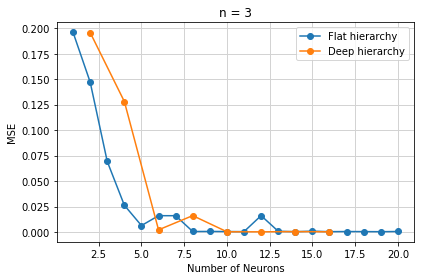

In [20]:
plt.title("n = 3")
plt.xlabel("Number of Neurons")
plt.ylabel("MSE")
plt.grid(color='lightgrey', linestyle='-', linewidth=1)
plt.plot(neurons_flat, minloss_flat, label='Flat hierarchy', marker='o')
plt.plot(neurons_deep, minloss_deep, label='Deep hierarchy', marker='o')
plt.tight_layout()
plt.legend()

#### 3. Interpretiere die Ergenisse für höhere Eingabedimensionen
Nachdem die Neuronenzahl, so gewählt wurde, dass sie Gleichung 5 entspricht, wird der Fehler meist nicht mehr kleiner. Manchmal (z.B. n=4) findet nochmal eine Minimierung statt, wenn man ein Neuron pro Schicht mehr nimmt, als Gleichung 5 angibt.  
Gleichung 5 scheint also zu stimmen.